In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms

!pip install kornia
!pip install kymatio
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential
from torch.utils.data import random_split

import numpy as np

import os
import time
from pathlib import Path
import pickle

from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

from kymatio.torch import Scattering2D

from collections import defaultdict

DEBUG = False
MODEL_NAME = "ScatResNet18_v1_100"
TRAIN_SIZE = 1000
VALIDATION_SIZE = 5000
env = 'kaggle' # 'kaggle' or 'colab'

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')
    base_dir = Path('/content/drive/MyDrive/dl_pj')    
elif env == 'kaggle':
    base_dir = Path('/kaggle/working/')

checkpoint_dir = base_dir / 'checkpoints'
checkpoint_dir.mkdir(parents=True, exist_ok=True)
training_stats_dir = base_dir / 'stats'
training_stats_dir.mkdir(parents=True, exist_ok=True)


Ls = [4, 6, 8, 10]
N_TIMES = 6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 3.1 MB/s eta 0:00:00


In [2]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(planes)
            )


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, L=8):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.L = L
        self.scat_channels = (1 + L) * 3
        self.conv1 = nn.Conv2d(3, 64 - self.scat_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.scat1 = Scattering2D(J=1, shape=(32, 32), L=L, max_order=2, backend='torch')
        self.deconv1 = nn.ConvTranspose2d(in_channels=self.scat_channels, out_channels=self.scat_channels, groups=self.scat_channels, kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layer = []
        for s in strides:
            layer.append(block(self.in_planes, planes, s))
            self.in_planes = planes
        return nn.Sequential(*layer)

    def forward(self, x):
        out = self.conv1(x)
        scat = self.scat1(x)
        scat = scat.view(scat.size(0), -1, 16,16)
        scat = self.deconv1(scat)
        out = torch.cat((out, scat), dim=1)
        out = F.relu(self.bn1(out))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ScatResNet18(L):
    return ResNet(BasicBlock, [2, 2, 2, 2], L=L)


In [3]:
def get_model_summary(model):
    num_params = sum(p.numel() for p in model.parameters())
    total_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
    size_mb = total_bytes / (1024 ** 2)
    return num_params, size_mb
for L in Ls:
    total_params, model_size_mb = get_model_summary(ScatResNet18(L))
    print(f"L {L} Total Parameters: {total_params:,}")
    print(f"L {L} Model Size: {model_size_mb:.2f} MB")

L 4 Total Parameters: 11,173,632
L 4 Model Size: 42.62 MB
L 6 Total Parameters: 11,173,500
L 6 Model Size: 42.62 MB
L 8 Total Parameters: 11,173,368
L 8 Model Size: 42.62 MB
L 10 Total Parameters: 11,173,236
L 10 Model Size: 42.62 MB


In [4]:
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode,  turn off Dropout, BatchNorm uses learned statistics
    total_correct = 0
    total_images = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            images = normalize(images)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=-1)
            total_images += labels.size(0)
            total_correct += (predictions == labels).sum().item()

    model_accuracy = total_correct / total_images * 100
    return model_accuracy


Split data set into train-validation-test.
We are using 80% train, 20% validation split

In [5]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()]
)

# 80/20% split
train_val_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)


targets = np.array(train_val_set.targets)

indices = np.arange(len(targets))
train_indices, remaining_indices = train_test_split(
    indices,
    train_size=TRAIN_SIZE,
    stratify=targets,
    random_state=42
)

validation_indices, _ = train_test_split(
    remaining_indices,
    train_size=VALIDATION_SIZE,
    stratify=targets[remaining_indices],
    random_state=42
)

trainset = Subset(train_val_set, train_indices)
valset = Subset(train_val_set, validation_indices)
print(f"Original size: {len(train_val_set)}")
print(f"Train size: {len(trainset)}")
print(f"Val size: {len(valset)}")

from collections import Counter 
subset_labels = [targets[i] for i in train_indices]
print("Samples per class", Counter(subset_labels))
subset_labels = [targets[i] for i in validation_indices]
print("Samples per class", Counter(subset_labels))

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


100%|██████████| 170M/170M [00:10<00:00, 15.5MB/s]


Original size: 50000
Train size: 1000
Val size: 5000
Samples per class Counter({np.int64(7): 100, np.int64(1): 100, np.int64(8): 100, np.int64(4): 100, np.int64(3): 100, np.int64(9): 100, np.int64(5): 100, np.int64(0): 100, np.int64(2): 100, np.int64(6): 100})
Samples per class Counter({np.int64(1): 500, np.int64(9): 500, np.int64(2): 500, np.int64(4): 500, np.int64(6): 500, np.int64(5): 500, np.int64(0): 500, np.int64(3): 500, np.int64(8): 500, np.int64(7): 500})


In [6]:
# Hyperparamters
batch_size = 128

lr = 0.1
momentum = 0.9
weight_decay = 5e-4

T_max = 200

n_epochs = 1 if DEBUG else 200

print_progress_every = 1
val_accuracy_storing_threshold = 40


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mean = torch.tensor([0.4914, 0.4822, 0.4465]).to(device)
std = torch.tensor([0.2023, 0.1994, 0.2010]).to(device)
normalize = K.Normalize(mean=mean, std=std)
# define a sequence of augmentations
aug_list = AugmentationSequential(
    K.RandomHorizontalFlip(p=0.5),
    K.ColorJitter(0.1, 0.1, 0.1, 0.1, p=0.2),
    K.RandomResizedCrop(size=(32,32), scale=(0.7, 1.0), p=0.5),
    normalize,
    same_on_batch=False
).to(device)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)
stats_list = defaultdict(list)
for N in range(0, N_TIMES):
    for L in Ls:
        model = ScatResNet18(L).to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)
        
        stats = {
            'total_training_time': 0,
            'loss': [],
            'time_per_epoch': [],
            'total_time_per_epoch': [],
            'val_accuracy': [],
            'max_val_accuracy': 0,
            'allocated_memory': [], # Memory currently used by Tensors
            'reserved_memory': [], # Memory held by the PyTorch caching allocator
        }
        
        start_time = time.time()
        for epoch in range(n_epochs):
            model.train()
            iteration_losses = []
            epoch_start_time = time.time()
            for inputs, targets in trainloader:
                inputs = inputs.to(device)
                targets = targets.to(device)
        
                inputs = aug_list(inputs)
        
                outputs = model(inputs)
        
                optimizer.zero_grad()
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                iteration_losses.append(loss.item())
        
            scheduler.step()
            epoch_end_time = time.time()
        
            model.eval()
            val_accuracy = calculate_accuracy(model, valloader, device)
        
            # Track stats
            if (epoch % 1) == 0:
                stats['loss'].append(
                    np.mean(iteration_losses)
                )
                stats['val_accuracy'].append(
                    val_accuracy
                )
                stats['allocated_memory'].append(torch.cuda.memory_allocated())
                stats['reserved_memory'].append(torch.cuda.memory_reserved())
                stats['time_per_epoch'].append(epoch_end_time - epoch_start_time)
                stats['total_time_per_epoch'].append(time.time() - start_time)
        
            # Store best model
            if (val_accuracy > stats['max_val_accuracy']):
                if (val_accuracy > val_accuracy_storing_threshold):
                    stats['max_val_accuracy'] = val_accuracy
                    print('==> Saving model ...')
                    state = {
                        'net': model.state_dict(),
                        'epoch': epoch,
                        'acc':val_accuracy
                    }
                    save_path = checkpoint_dir / f"{MODEL_NAME}_L{L}_N{N}_max_acc.pth"
                    torch.save(state, save_path)
        
            if DEBUG:
                print('==> Saving model ... DEBUG')
                state = {
                    'net': model.state_dict(),
                    'epoch': epoch,
                    'acc':val_accuracy
                }
                save_path = checkpoint_dir / f"{MODEL_NAME}_L{L}_N{N}_max_acc.pth"
                torch.save(state, save_path)
                
            # Print progress
            if (epoch % print_progress_every) == 0:
                print(f"L {L} Epoch {epoch} Loss {stats['loss'][-1]:.3f} Val Acc {stats['val_accuracy'][-1]:.3f}")
        
        stats_list[L].append(stats)


L 4 Epoch 0 Loss 4.483 Val Acc 10.000
L 4 Epoch 1 Loss 4.255 Val Acc 10.020
L 4 Epoch 2 Loss 3.398 Val Acc 10.180
L 4 Epoch 3 Loss 2.876 Val Acc 11.360
L 4 Epoch 4 Loss 2.877 Val Acc 14.760
L 4 Epoch 5 Loss 3.047 Val Acc 20.020
L 4 Epoch 6 Loss 2.600 Val Acc 21.460
L 4 Epoch 7 Loss 2.300 Val Acc 23.340
L 4 Epoch 8 Loss 2.132 Val Acc 24.640
L 4 Epoch 9 Loss 2.095 Val Acc 26.920
L 4 Epoch 10 Loss 2.058 Val Acc 25.320
L 4 Epoch 11 Loss 1.919 Val Acc 28.240
L 4 Epoch 12 Loss 1.836 Val Acc 29.880
L 4 Epoch 13 Loss 1.784 Val Acc 29.440
L 4 Epoch 14 Loss 1.746 Val Acc 30.780
L 4 Epoch 15 Loss 1.673 Val Acc 35.920
L 4 Epoch 16 Loss 1.628 Val Acc 37.040
L 4 Epoch 17 Loss 1.549 Val Acc 37.240
L 4 Epoch 18 Loss 1.596 Val Acc 37.600
L 4 Epoch 19 Loss 1.503 Val Acc 39.100
L 4 Epoch 20 Loss 1.530 Val Acc 37.400
L 4 Epoch 21 Loss 1.477 Val Acc 36.760
L 4 Epoch 22 Loss 1.517 Val Acc 37.400
==> Saving model ...
L 4 Epoch 23 Loss 1.467 Val Acc 40.740
==> Saving model ...
L 4 Epoch 24 Loss 1.404 Val Acc 

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
L_test_accs = defaultdict(list)
for L in Ls:
    for N in range(0, N_TIMES):
        model = ScatResNet18(L).to(device)
        checkpoint = torch.load(checkpoint_dir / f"{MODEL_NAME}_L{L}_N{N}_max_acc.pth", map_location=device)
        model.load_state_dict(checkpoint['net'])
        model.eval()

        stats = stats_list[L][N]
        total_params, model_size_mb = get_model_summary(ScatResNet18(L))
        stats['total_params'] = total_params
        stats['model_size_mb'] = model_size_mb
        stats['train_acc'] = calculate_accuracy(model, trainloader, device)
        stats['val_acc'] = calculate_accuracy(model, valloader, device)
        stats['test_acc'] = calculate_accuracy(model, testloader, device)
        
        print(f'Final test accuracy  for L {L} N {N} is: {stats['test_acc']:.3f}')
        print(f'Final val accuracy   for L {L} N {N} is: {stats['val_acc']:.3f}')
        print(f'Final train accuracy for L {L} N {N} is: {stats['train_acc']:.3f}')
        
        with open(training_stats_dir / f'{MODEL_NAME}_L{L}_N{N}_stats.pkl', 'wb') as file:
            pickle.dump(stats, file)
        L_test_accs[L].append(stats['test_acc'])

Final test accuracy  for L 4 N 0 is: 55.280
Final val accuracy   for L 4 N 0 is: 56.680
Final train accuracy for L 4 N 0 is: 100.000
Final test accuracy  for L 4 N 1 is: 55.090
Final val accuracy   for L 4 N 1 is: 54.940
Final train accuracy for L 4 N 1 is: 100.000
Final test accuracy  for L 4 N 2 is: 55.270
Final val accuracy   for L 4 N 2 is: 54.760
Final train accuracy for L 4 N 2 is: 100.000
Final test accuracy  for L 4 N 3 is: 56.070
Final val accuracy   for L 4 N 3 is: 55.900
Final train accuracy for L 4 N 3 is: 100.000
Final test accuracy  for L 4 N 4 is: 56.930
Final val accuracy   for L 4 N 4 is: 57.320
Final train accuracy for L 4 N 4 is: 100.000
Final test accuracy  for L 4 N 5 is: 55.270
Final val accuracy   for L 4 N 5 is: 54.460
Final train accuracy for L 4 N 5 is: 100.000
Final test accuracy  for L 6 N 0 is: 59.230
Final val accuracy   for L 6 N 0 is: 58.980
Final train accuracy for L 6 N 0 is: 100.000
Final test accuracy  for L 6 N 1 is: 53.890
Final val accuracy   for 

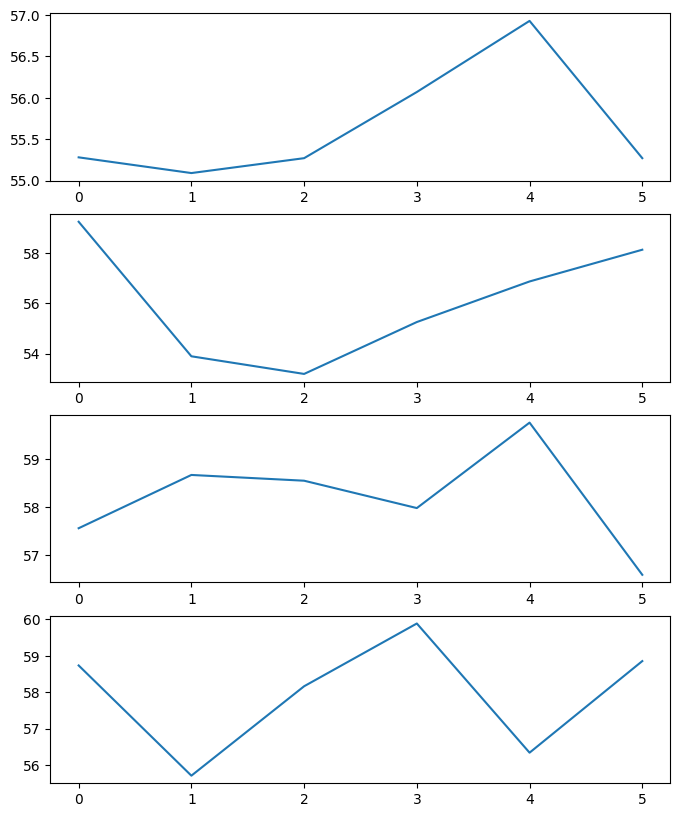

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=1, nrows=len(Ls), figsize=(8,10))
for i, L in enumerate(Ls):
    ax[i].plot(L_test_accs[L])

In [10]:
for L in Ls:
    print(f"Mean     for L {L}: {np.mean(L_test_accs[L]):.3f}")
    print(f"Variance for L {L}: {np.var(L_test_accs[L]):.3f}")
    

Mean     for L 4: 55.652
Variance for L 4: 0.426
Mean     for L 6: 56.090
Variance for L 6: 4.755
Mean     for L 8: 58.175
Variance for L 8: 0.971
Mean     for L 10: 57.945
Variance for L 10: 2.133
